In [ ]:
import json
import numpy as np
import random
import nltk
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:


# Load the intents file
with open('intents.json', 'r') as f:
    intents = json.load(f)

# Extract the patterns and their tags
patterns = []
tags = []
for intent in intents['intents']:
    for pattern in intent['patterns']:
        patterns.append(pattern.lower())
        tags.append(intent['tag'])

# Tokenize the patterns
word_tokens = []
for pattern in patterns:
    word_tokens.append(nltk.word_tokenize(pattern))

# Lemmatize the words and remove duplicates
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set()
for tokens in word_tokens:
    words.update([lemmatizer.lemmatize(w.lower()) for w in tokens if w.isalpha()])

# Create a dictionary to map words to integers
word_dict = {}
for i, word in enumerate(words):
    word_dict[word] = i + 1

# Create a dictionary to map tags to integers
tag_dict = {}
for i, tag in enumerate(set(tags)):
    tag_dict[tag] = i

# Convert patterns and tags to integer sequences
pattern_sequences = []
tag_sequences = []
for i, tokens in enumerate(word_tokens):
    pattern_sequence = [word_dict[lemmatizer.lemmatize(w.lower())] for w in tokens if w.isalpha()]
    pattern_sequences.append(pattern_sequence)
    tag_sequences.append(tag_dict[tags[i]])

# Pad pattern sequences to ensure they are all the same length
max_len = max([len(seq) for seq in pattern_sequences])
padded_pattern_sequences = pad_sequences(pattern_sequences, padding='post', maxlen=max_len)

# Convert tag sequences to one-hot encoding
tag_one_hot = keras.utils.to_categorical(tag_sequences)

# Define the model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(len(word_dict) + 1, 128, input_length=max_len)(input_layer)
lstm_layer = LSTM(128)(embedding_layer)
dropout_layer = Dropout(0.5)(lstm_layer)
output_layer = Dense(len(tag_dict), activation='softmax')(dropout_layer)
model = Model(inputs=[input_layer], outputs=[output_layer])

# Compile the model
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])



Epoch 1/200
109/109 [==============================] - 6s 32ms/step - loss: 3.5793 - accuracy: 0.0986 - val_loss: 3.4824 - val_accuracy: 0.1078
Epoch 2/200
109/109 [==============================] - 3s 27ms/step - loss: 3.5227 - accuracy: 0.0940 - val_loss: 3.4673 - val_accuracy: 0.1078
Epoch 3/200
109/109 [==============================] - 3s 27ms/step - loss: 3.4995 - accuracy: 0.0975 - val_loss: 3.4703 - val_accuracy: 0.1078
Epoch 4/200
109/109 [==============================] - 4s 36ms/step - loss: 3.4949 - accuracy: 0.1101 - val_loss: 3.4697 - val_accuracy: 0.1078
Epoch 5/200
109/109 [==============================] - 3s 27ms/step - loss: 3.4978 - accuracy: 0.1009 - val_loss: 3.4699 - val_accuracy: 0.1078
Epoch 6/200
109/109 [==============================] - 3s 27ms/step - loss: 3.4877 - accuracy: 0.1078 - val_loss: 3.4649 - val_accuracy: 0.1078
Epoch 7/200
109/109 [==============================] - 3s 27ms/step - loss: 3.4923 - accuracy: 0.1101 - val_loss: 3.4622 - val_accuracy:

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Load the test data
with open('intents_testing.json', 'r') as f:
    intents_testing = json.load(f)

# Extract the patterns and their tags
patterns_testing = []
tags_testing = []
for intent in intents_testing['intents']:
    for pattern in intent['patterns']:
        patterns_testing.append(pattern.lower())
        tags_testing.append(intent['tag'])

# Tokenize the patterns
word_tokens_testing = []
for pattern in patterns_testing:
    word_tokens_testing.append(nltk.word_tokenize(pattern))

# Convert patterns and tags to integer sequences
pattern_sequences_testing = []
tag_sequences_testing = []
for i, tokens in enumerate(word_tokens_testing):
    pattern_sequence_testing = [word_dict.get(lemmatizer.lemmatize(w.lower()), 0) for w in tokens if w.isalpha()]
    pattern_sequences_testing.append(pattern_sequence_testing)
    tag_sequences_testing.append(tag_dict[tags_testing[i]])

# Pad pattern sequences to ensure they are all the same length
padded_pattern_sequences_testing = pad_sequences(pattern_sequences_testing, padding='post', maxlen=max_len)

# Convert tag sequences to one-hot encoding
tag_one_hot_testing = keras.utils.to_categorical(tag_sequences_testing)



Test loss: 3.500, accuracy: 0.105
3/3 [==============================] - 1s 13ms/step
Precision: 0.039, recall: 0.105, F1-score: 0.051


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
hist=model.fit(padded_pattern_sequences, tag_one_hot,validation_data=(padded_pattern_sequences_testing, tag_one_hot_testing), epochs=200, batch_size=8)


In [ ]:

# Evaluate the model on test set
loss, accuracy = model.evaluate(padded_pattern_sequences_testing, tag_one_hot_testing, verbose=0)
print(f'Test loss: {loss:.3f}, accuracy: {accuracy:.3f}')

# Calculate precision, recall, and F1-score
y_true = np.argmax(tag_one_hot_testing, axis=1)
y_pred = np.argmax(model.predict(padded_pattern_sequences_testing), axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.3f}, recall: {recall:.3f}, F1-score: {f1_score:.3f}')

In [ ]:
from sklearn.metrics import classification_report

# Generate predictions on the training data
train_pred = np.argmax(model.predict(padded_pattern_sequences), axis=1)

# Convert one-hot encoded predictions to tag sequences
# train_pred_tags = [tag_dict[idx] for idx in np.argmax(train_pred, axis=1)]

# Compute metrics
train_report = classification_report(tag_sequences, train_pred)

print("Training data metrics:\n", train_report)


28/28 [==============================] - 0s 15ms/step
Training data metrics:
               precision    recall  f1-score   support

           0       0.49      0.94      0.65        94
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        11
           9       0.40      0.04      0.07        52
          10       0.19      0.10      0.13        42
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         6
          13       0.23      0.87      0.36        38
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00        11
   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


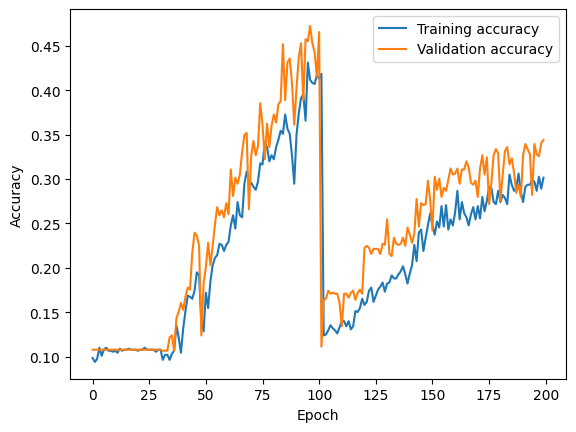

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over time
plt.plot(hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



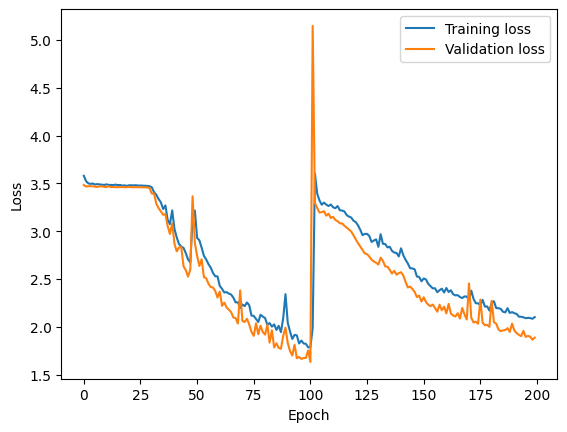

In [ ]:
# Plot the training and validation loss over time
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(tag_dict)).numpy()

# Get the indices for true positive, true negative, false positive, and false negative
tp_idx = np.diag(confusion_matrix)
tn_idx = np.diag(np.fliplr(confusion_matrix))
fp_idx = np.sum(confusion_matrix, axis=0) - tp_idx
fn_idx = np.sum(confusion_matrix, axis=1) - tp_idx

# Compute true positive, true negative, false positive, and false negative
tp = np.sum(tp_idx)
tn = np.sum(tn_idx)
fp = np.sum(fp_idx)
fn = np.sum(fn_idx)

print('True positives:', tp)
print('True negatives:', tn)
print('False positives:', fp)
print('False negatives:', fn)



True positives: 8
True negatives: 3
False positives: 68
False negatives: 68


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Convert tag sequences to integer labels
tag_labels = np.argmax(tag_one_hot, axis=1)

# Define the cross-validation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = []
for train_idx, test_idx in cv.split(padded_pattern_sequences, tag_labels):
    # Split data into training and test sets
    X_train, X_test = padded_pattern_sequences[train_idx], padded_pattern_sequences[test_idx]
    y_train, y_test = tag_one_hot[train_idx], tag_one_hot[test_idx]

    # Define the model
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(len(word_dict) + 1, 128, input_length=max_len)(input_layer)
    lstm_layer = LSTM(128)(embedding_layer)
    dropout_layer = Dropout(0.5)(lstm_layer)
    output_layer = Dense(len(tag_dict), activation='softmax')(dropout_layer)
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile the model
    sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=8)

    # Evaluate the model on the test set
    score = model.evaluate(X_test, y_test)[1]
    scores.append(score)

# Compute the mean and standard deviation of the scores
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Cross-validation accuracy: {:.2f} +/- {:.2f}".format(mean_score, std_score))


Epoch 1/200
88/88 [==============================] - 6s 39ms/step - loss: 3.6003 - accuracy: 0.0832 - val_loss: 3.4986 - val_accuracy: 0.0743
Epoch 2/200
88/88 [==============================] - 2s 26ms/step - loss: 3.5324 - accuracy: 0.0818 - val_loss: 3.4848 - val_accuracy: 0.1086
Epoch 3/200
88/88 [==============================] - 2s 26ms/step - loss: 3.5151 - accuracy: 0.1047 - val_loss: 3.4726 - val_accuracy: 0.1086
Epoch 4/200
88/88 [==============================] - 2s 27ms/step - loss: 3.5080 - accuracy: 0.1033 - val_loss: 3.4696 - val_accuracy: 0.1086
Epoch 5/200
88/88 [==============================] - 3s 32ms/step - loss: 3.5057 - accuracy: 0.1004 - val_loss: 3.4692 - val_accuracy: 0.1086
Epoch 6/200
88/88 [==============================] - 3s 31ms/step - loss: 3.4963 - accuracy: 0.1019 - val_loss: 3.4640 - val_accuracy: 0.1086
Epoch 7/200
88/88 [==============================] - 2s 27ms/step - loss: 3.4955 - accuracy: 0.0990 - val_loss: 3.4708 - val_accuracy: 0.1086
Epoch 